## Download Dataset



In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qvXyV91zG1dqp9P8vv0i")
project = rf.workspace("virli").project("face-skin")
version = project.version(11)
dataset = version.download("yolov5-obb")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-Skin-11 in yolov5-obb:: 100%|██████████| 990/990 [00:00<00:00, 8372.96it/s]


## Library

In [2]:
import os
import tensorflow as tf
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

### Proccesing Data
Membaca Dataset, Resize, Dan Normalisasi

In [3]:
import os
import cv2
import numpy as np

# Path ke folder gambar dan anotasi YOLO
train_image_dir = '/content/Face-Skin-11/train/images'
train_annotations_dir = '/content/Face-Skin-11/train/labelTxt'
valid_image_dir = '/content/Face-Skin-11/valid/images'
valid_annotations_dir = '/content/Face-Skin-11/valid/labelTxt'
test_image_dir = '/content/Face-Skin-11/test/images'
test_annotations_dir = '/content/Face-Skin-11/test/labelTxt'

# Daftar kelas penyakit
classes = ['acne scar', 'blackheads', 'darkspot', 'whiteheads']

# Ukuran Resize
target_size = (224, 224)

# Fungsi untuk membaca file anotasi YOLO
def parse_yolo_annotation(annotation_file):
    annotations = []
    if not os.path.exists(annotation_file):
        print(f"Warning: Annotation file {annotation_file} does not exist.")

        return annotations

    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                print(f"Warning: Invalid annotation format in {annotation_file}. Using empty annotations.")
                annotations.append((0, 0.0, 0.0, 0.0, 0.0))
                continue
            try:
                class_id = int(float(parts[0]))
                if class_id >= len(classes):
                    print(f"Warning: Class ID {class_id} not in class list. Using default annotation.")
                    annotations.append((0, 0.0, 0.0, 0.0, 0.0))
                    continue
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                annotations.append((class_id, x_center, y_center, width, height))
            except ValueError:
                print(f"Warning: Error reading annotation in {annotation_file}. Using empty annotation.")
                annotations.append((0, 0.0, 0.0, 0.0, 0.0))
    return annotations

# Menyimpan anotasi YOLO
def save_yolo_annotation(file_path, annotations):
    with open(file_path, 'w') as f:
        for ann in annotations:
            f.write(f"{ann[0]} {ann[1]:.6f} {ann[2]:.6f} {ann[3]:.6f} {ann[4]:.6f}\n")

# Membaca dataset, Resize, dan Normalisasi gambar
def read_and_process_dataset(image_dir, annotations_dir, target_size=(224, 224)):
    dataset = []
    for image_name in os.listdir(image_dir):
        if not image_name.endswith('.jpg'):
            continue

        # Path gambar dan anotasi
        image_path = os.path.join(image_dir, image_name)
        annotation_path = os.path.join(annotations_dir, image_name.replace('.jpg', '.txt'))

        # File gambar ada
        if not os.path.exists(image_path):
            print(f"Warning: Image file {image_name} not found. Using empty image.")
            image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        else:
            # Membaca gambar
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Failed to read image {image_name}. Using empty image.")
                image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

        # Resize gambar
        image = cv2.resize(image, target_size)

        # Normalisasi gambar
        image = image / 255.0

        # Membaca anotasi YOLO
        annotations = parse_yolo_annotation(annotation_path)

        dataset.append((image, annotations))

    print(f"Loaded {len(dataset)} images and annotations.")
    return dataset

train_dataset = read_and_process_dataset(train_image_dir, train_annotations_dir)
valid_dataset = read_and_process_dataset(valid_image_dir, valid_annotations_dir)
test_dataset = read_and_process_dataset(test_image_dir, test_annotations_dir)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Loaded 325 images and annotations.
Loaded 78 images and annotations.
Loaded 86 images and annotations.
Train dataset size: 325
Valid dataset size: 78
Test dataset size: 86


### Membuat Model

In [6]:
from tensorflow.keras import layers, models
import tensorflow as tf

def create_light_detection_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    detection_output = layers.Dense(num_classes * 5, activation='sigmoid', name='detection_output')(x)

    model = models.Model(
        inputs=inputs,
        outputs=detection_output,
        name='light_detector'
    )

    class_true_var = tf.Variable(0, dtype=tf.int64)
    class_pred_var = tf.Variable(0, dtype=tf.int64)

    @tf.function
    def detection_accuracy(y_true, y_pred):
        y_pred_reshaped = tf.reshape(y_pred, [-1, num_classes, 5])
        y_true_reshaped = tf.reshape(y_true, [-1, num_classes, 5])

        class_pred = tf.argmax(y_pred_reshaped[..., 0], axis=-1)
        class_true = tf.argmax(y_true_reshaped[..., 0], axis=-1)

        accuracy = tf.reduce_mean(tf.cast(tf.equal(class_pred, class_true), tf.float32))
        return accuracy

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[detection_accuracy]
    )

    return model

model = create_light_detection_model(
    input_shape=(224, 224, 3),
    num_classes=4
)

model.summary()

Model: "light_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │         401,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ detection_output (Dense)             │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,628 (1.63 MB)

 Trainable params: 426,628 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def prepare_data_with_padding(dataset, max_boxes=10):
    x_data = []
    y_data = []
    for image, annotations in dataset:
        x_data.append(image)

        reshaped_annotations = [0.0] * (4 * 5)
        for class_id, x_center, y_center, width, height in annotations:
            start_index = class_id * 5
            reshaped_annotations[start_index] = 1.0
            reshaped_annotations[start_index + 1] = x_center
            reshaped_annotations[start_index + 2] = y_center
            reshaped_annotations[start_index + 3] = width
            reshaped_annotations[start_index + 4] = height
        y_data.append(reshaped_annotations)
    return np.array(x_data), np.array(y_data)

x_train, y_train = prepare_data_with_padding(train_dataset, max_boxes=10)
x_valid, y_valid = prepare_data_with_padding(valid_dataset, max_boxes=10)
x_test, y_test = prepare_data_with_padding(test_dataset, max_boxes=10)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_valid = tf.convert_to_tensor(y_valid, dtype=tf.float32)

### Training Model

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [9]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_valid, y_valid),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - detection_accuracy: 0.4089 - loss: 0.2037 - val_detection_accuracy: 1.0000 - val_loss: 0.0905
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - detection_accuracy: 0.7447 - loss: 0.1426 - val_detection_accuracy: 1.0000 - val_loss: 0.0713
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - detection_accuracy: 0.7251 - loss: 0.1327 - val_detection_accuracy: 1.0000 - val_loss: 0.0478
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - detection_accuracy: 0.8401 - loss: 0.1087 - val_detection_accuracy: 1.0000 - val_loss: 0.0274
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - detection_accuracy: 0.8138 - loss: 0.1025 - val_detection_accuracy: 1.0000 - val_loss: 0.0266
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - detection_accuracy: 0.8348 - loss: 0.0871 - val_detection_accuracy: 1.0000 - val_loss: 0.0175
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - detection_accuracy: 0.8442 - loss: 0.0812 - val_detection_accuracy: 1.0000 - val_loss:

### Visualisasi Training

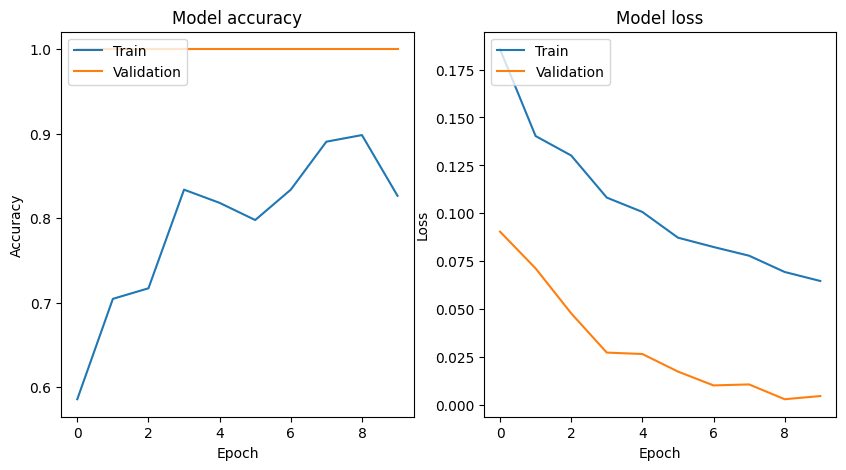

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['detection_accuracy'])
plt.plot(history.history['val_detection_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Simpan Model

In [12]:
model.save('skincam_model.h5')

### Pembuatan Logika


Menguji gambar: levle2_138_png.rf.0e7d7e229189d04a3409507d737ddd2e.jpg


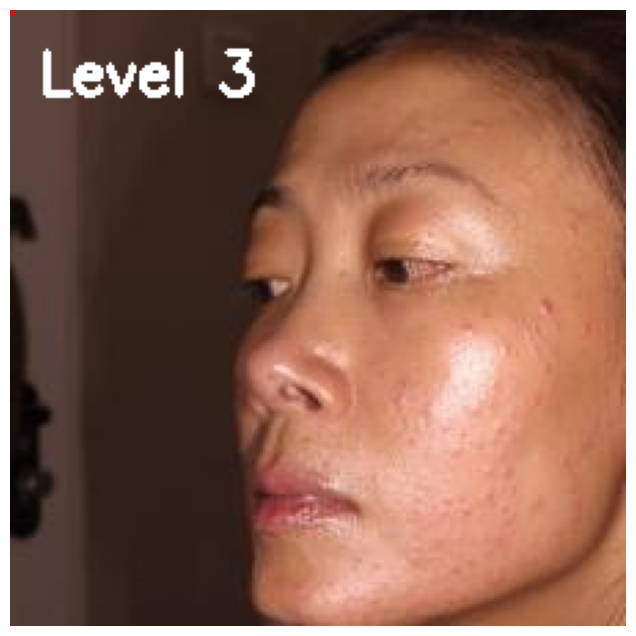


Detail Deteksi untuk levle2_138_png.rf.0e7d7e229189d04a3409507d737ddd2e.jpg:
acne scar: 21 deteksi
Level Keparahan: 3
Deskripsi: Level 3 (Kulit wajah mengalami kerusakan parah)


In [13]:
model = tf.keras.models.load_model('skincam_model.h5')

def calculate_severity_level(detections):

    class_detections = {}
    for detection in detections:
        class_id = detection[0]
        if class_id not in class_detections:
            class_detections[class_id] = 1
        else:
            class_detections[class_id] += 1

    if 3 in class_detections:
        del class_detections[3]

    num_classes_detected = len(class_detections)

    total_bboxes = sum(class_detections.values())

    if num_classes_detected == 0:
        return 0  # Kulit wajah sehat (normal)
    elif num_classes_detected == 1 and total_bboxes <= 3:
        return 1  # Level 1: 1 kelas, <3 bbox
    elif num_classes_detected == 2 and total_bboxes <= 4:
        return 2  # Level 2: 2 kelas, <4 bbox
    elif num_classes_detected == 3 and total_bboxes >= 5:
        return 3  # Level 3: 3 kelas, <5 bbox
    else:
        return 3  # Default ke level tertinggi jika melebihi kriteria

def get_level_description(level):
    descriptions = {
        0: "Level 0 (Kulit wajah sehat)",
        1: "Level 1 (Kulit wajah mengalami kerusakan ringan)",
        2: "Level 2 (Kulit wajah mengalami kerusakan sedang)",
        3: "Level 3 (Kulit wajah mengalami kerusakan parah)"
    }
    return descriptions.get(level, "Level tidak valid")

def process_detection_results(detections):
    level = calculate_severity_level(detections)
    description = get_level_description(level)
    return level, description

def example_usage(image_path, annotation_path):
    annotations = parse_yolo_annotation(annotation_path)

    level, description = process_detection_results(annotations)

    print(f"Level: {level}")
    print(f"Deskripsi: {description}")

    print("\nDetail deteksi:")
    class_counts = {}
    for ann in annotations:
        class_name = classes[ann[0]]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1

    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} deteksi")

def visualize_single_image(image_path, annotation_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]

    annotations = parse_yolo_annotation(annotation_path)

    level, description = process_detection_results(annotations)

    colors = {
        0: (255, 0, 0),    # Merah untuk acne scar
        1: (0, 255, 0),    # Hijau untuk blackheads
        2: (0, 0, 255),    # Biru untuk darkspot
        3: (255, 255, 0),  # Kuning untuk normal
        4: (255, 0, 255)   # Magenta untuk whiteheads
    }

    for ann in annotations:
        class_id, x_center, y_center, w, h = ann

        x = int((x_center) * width)
        y = int((y_center) * height)
        w = int(w * width)
        h = int(h * height)

        x_min = max(0, x - w//2)
        y_min = max(0, y - h//2)
        x_max = min(width, x + w//2)
        y_max = min(height, y + h//2)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[class_id], 2)

        class_name = classes[class_id]
        label = f"{class_name}"
        cv2.putText(image, label, (x_min, y_min-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    info_text = f"Level {level}: {description}"
    y_pos = 30

    cv2.putText(image, f"Level {level}", (10, y_pos),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print(f"\nDetail Deteksi untuk {os.path.basename(image_path)}:")
    class_counts = {}
    for ann in annotations:
        class_name = classes[ann[0]]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1

    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} deteksi")

    print(f"Level Keparahan: {level}")
    print(f"Deskripsi: {description}")

def test_specific_image(image_name):
    try:
        image_path = os.path.join(test_image_dir, image_name)
        annotation_path = os.path.join(test_annotations_dir, image_name.replace('.jpg', '.txt'))

        print(f"\nMenguji gambar: {image_name}")
        visualize_single_image(image_path, annotation_path)
    except Exception as e:
        print(f"Error occurred: {str(e)}")


# Menguji satu gambar spesifik
test_specific_image("levle2_138_png.rf.0e7d7e229189d04a3409507d737ddd2e.jpg")


### Menyimpan Dataset

In [ ]:
import shutil

folder_path = '/content/Face-Skin-11/test'

zip_filename = 'face-skin-test.zip'

shutil.make_archive(zip_filename, 'zip', folder_path)

print(f"Folder '{folder_path}' berhasil di-zip menjadi '{zip_filename}'")

Folder '/content/Face-Skin-11/test' berhasil di-zip menjadi 'face-skin-test.zip'
